# Integrated Pressure, Seismic, and Dissolved Oxygen Feature Analysis

This notebook analyzes the relationship between seafloor pressure, seismic features, and dissolved oxygen at Southern Hydrate Ridge.

## Workflow:
1. Load and parse MASSPA dissolved oxygen data files
2. Load seismic features and extract temporal structure
3. Load and align pressure data to seismic time bins
4. Align dissolved oxygen data to seismic time bins
5. Extract features from all three data types
6. Plot raw feature distributions
7. Standardize features (demean and scale)
8. Plot standardized feature distributions
9. Compute feature cross-correlations
10. Apply PCA to identify variance-explaining features

## 2. Setup and Imports

## 1. Parse MASSPA Dissolved Oxygen Data

In [9]:
import glob
import re
from datetime import datetime

# Find all MASSPA data files
masspa_files = sorted(glob.glob('MASSPA*.dat'))

print(f"Found {len(masspa_files)} MASSPA data files")
print(f"Date range: {masspa_files[0][-22:-8]} to {masspa_files[-1][-22:-8]}")
print(f"\nFirst file: {masspa_files[0]}")
print(f"Last file: {masspa_files[-1]}")

Found 31 MASSPA data files
Date range: _20180701T0000 to _20180731T0000

First file: MASSPA101_10.33.7.6_4003_20180701T0000_UTC.dat
Last file: MASSPA101_10.33.7.6_4003_20180731T0000_UTC.dat


In [12]:
masspa_files[0]

'MASSPA101_10.33.7.6_4003_20180701T0000_UTC.dat'

In [13]:
with open(masspa_files[0], 'r') as f:
    for line in f:
        ts_match = re.search(r'<log-ts:([\d\-T:\.]+)>', line)
        print(ts_match)

        int_match = re.search(r'INT:([\d:\-]+)', line)
        print(int_match)

        ext_match = re.search(r'EXT:([\d\.\-:]+)', line)
        print(ext_match)

        print()


<re.Match object; span=(0, 32), match='<log-ts:2018-07-01T00:00:26.676>'>
<re.Match object; span=(117, 156), match='INT:46:1:26:-127:-127:19:22:11:10:10:11'>
<re.Match object; span=(157, 177), match='EXT:-1.00:0.00:-1.00'>

<re.Match object; span=(0, 32), match='<log-ts:2018-07-01T00:01:01.846>'>
<re.Match object; span=(117, 156), match='INT:46:1:25:-127:-127:19:22:11:10:10:11'>
<re.Match object; span=(157, 177), match='EXT:-1.00:0.00:-1.00'>

<re.Match object; span=(0, 32), match='<log-ts:2018-07-01T00:01:37.018>'>
<re.Match object; span=(117, 156), match='INT:46:1:26:-127:-127:19:22:11:10:10:11'>
<re.Match object; span=(157, 177), match='EXT:-1.00:0.00:-1.00'>

<re.Match object; span=(0, 32), match='<log-ts:2018-07-01T00:02:10.188>'>
<re.Match object; span=(117, 156), match='INT:46:1:26:-127:-127:19:22:11:10:10:11'>
<re.Match object; span=(157, 177), match='EXT:-1.00:0.00:-1.00'>

<re.Match object; span=(0, 32), match='<log-ts:2018-07-01T00:02:45.358>'>
<re.Match object; span=(117, 1

In [10]:
def parse_masspa_line(line):
    """
    Parse a single line from MASSPA data file.
    
    Format: <log-ts:TIMESTAMP> DATA,POW:...,PRE:...,INT:...,EXT:...,EXTST:...,POWST:...,SOLST:...,CAL:...,HEAT:...,ENDDATA
    
    INT field contains dissolved oxygen data (4th value = oxygen sensor reading)
    """
    # Extract timestamp
    ts_match = re.search(r'<log-ts:([\d\-T:\.]+)>', line)
    if not ts_match:
        return None
    
    timestamp = pd.to_datetime(ts_match.group(1))
    
    # Extract INT field (internal sensors including dissolved oxygen)
    int_match = re.search(r'INT:([\d:\-]+)', line)
    if not int_match:
        return None
    
    int_values = int_match.group(1).split(':')
    
    # Extract EXT field (external sensors - dissolved oxygen in first position)
    ext_match = re.search(r'EXT:([\d\.\-:]+)', line)
    if not ext_match:
        return None
    
    ext_values = ext_match.group(1).split(':')
    
    try:
        # EXT first value is dissolved oxygen (in mg/L or similar units)
        dissolved_oxygen = float(ext_values[0])
        
        return {
            'time': timestamp,
            'dissolved_oxygen': dissolved_oxygen
        }
    except (ValueError, IndexError):
        return None

print("MASSPA parsing function defined")

MASSPA parsing function defined


In [11]:
# Parse all MASSPA files and combine into one dataframe
print("Parsing MASSPA files...")

all_oxygen_data = []

for i, filepath in enumerate(masspa_files):
    with open(filepath, 'r') as f:
        for line in f:
            parsed = parse_masspa_line(line)
            if parsed:
                all_oxygen_data.append(parsed)
    
    if (i + 1) % 5 == 0:
        print(f"  Processed {i + 1}/{len(masspa_files)} files...")

# Create DataFrame
oxygen_df = pd.DataFrame(all_oxygen_data)

print(f"\nParsed {len(oxygen_df)} dissolved oxygen records")
print(f"Date range: {oxygen_df['time'].min()} to {oxygen_df['time'].max()}")
print(f"\nDissolved oxygen statistics:")
print(oxygen_df['dissolved_oxygen'].describe())

oxygen_df.head(10)

Parsing MASSPA files...
  Processed 5/31 files...
  Processed 10/31 files...
  Processed 15/31 files...
  Processed 20/31 files...
  Processed 25/31 files...
  Processed 30/31 files...

Parsed 77254 dissolved oxygen records
Date range: 2018-07-01 00:00:26.676000 to 2018-07-31 23:59:26.851000

Dissolved oxygen statistics:
count    77254.000000
mean        -1.301486
std          0.459442
min         -2.000000
25%         -2.000000
50%         -1.000000
75%         -1.000000
max          0.000000
Name: dissolved_oxygen, dtype: float64


,time,dissolved_oxygen
0,2018-07-01 00:00:26.676,-1.0
1,2018-07-01 00:01:01.846,-1.0
2,2018-07-01 00:01:37.018,-1.0
3,2018-07-01 00:02:10.188,-1.0
4,2018-07-01 00:02:45.358,-1.0
5,2018-07-01 00:03:20.578,-1.0
6,2018-07-01 00:03:55.749,-2.0
7,2018-07-01 00:04:28.919,-1.0
8,2018-07-01 00:05:04.040,-1.0
9,2018-07-01 00:05:39.311,-1.0


In [186]:
# Save parsed oxygen data to CSV for future use
oxygen_csv_path = 'masspa_dissolved_oxygen_2018.csv'
oxygen_df.to_csv(oxygen_csv_path, index=False)
print(f"Saved dissolved oxygen data to {oxygen_csv_path}")

Saved dissolved oxygen data to masspa_dissolved_oxygen_2018.csv


In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('dark_background')

print("Libraries imported successfully")

Libraries imported successfully


## 3. Load Seismic Data and Extract Temporal Structure

In [188]:
# Load seismic features
seismic_df = pd.read_csv('seismic_features_full_2018_limited_dates.csv')

# Convert time columns to datetime
seismic_df['starttime'] = pd.to_datetime(seismic_df['starttime'])
seismic_df['endtime'] = pd.to_datetime(seismic_df['endtime'])
seismic_df['date'] = pd.to_datetime(seismic_df['date'])

print(f"Loaded {len(seismic_df)} seismic records")
print(f"\nDate range: {seismic_df['date'].min()} to {seismic_df['date'].max()}")
print(f"\nTime bins: 1-minute chunks")
print(f"Unique dates: {seismic_df['date'].nunique()}")
print(f"Unique stations: {seismic_df['station_name'].nunique()}")

seismic_df.head()

Loaded 211680 seismic records

Date range: 2018-06-29 00:00:00 to 2018-12-31 00:00:00

Time bins: 1-minute chunks
Unique dates: 147
Unique stations: 1


,station_name,station_lat,station_lon,station_elev,date_range_index,date,chunk_index,starttime,endtime,E_max,...,Z_max,Z_min,Z_median,Z_mean,Z_freq1,Z_freq2,Z_freq3,Z_power1,Z_power2,Z_power3
0,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,0,2018-06-29 01:40:56.029000+00:00,2018-06-29 01:41:56.029000+00:00,0.0,...,0.0,0.0,0.0,0.0,99.991667,33.363886,33.213899,0.0,0.0,0.0
1,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,1,2018-06-29 01:41:56.029000+00:00,2018-06-29 01:42:56.029000+00:00,0.0,...,0.0,0.0,0.0,0.0,99.991667,33.363886,33.213899,0.0,0.0,0.0
2,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,2,2018-06-29 01:42:56.029000+00:00,2018-06-29 01:43:56.029000+00:00,0.0,...,0.0,0.0,0.0,0.0,99.991667,33.363886,33.213899,0.0,0.0,0.0
3,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,3,2018-06-29 01:43:56.029000+00:00,2018-06-29 01:44:56.029000+00:00,0.0,...,0.0,0.0,0.0,0.0,99.991667,33.363886,33.213899,0.0,0.0,0.0
4,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,4,2018-06-29 01:44:56.029000+00:00,2018-06-29 01:45:56.029000+00:00,0.0,...,0.0,0.0,0.0,0.0,99.991667,33.363886,33.213899,0.0,0.0,0.0


In [189]:
# Display seismic feature columns
print("Seismic feature columns:")
feature_cols = [col for col in seismic_df.columns if any(comp in col for comp in ['E_', 'N_', 'Z_'])]
for col in feature_cols:
    print(f"  - {col}")

Seismic feature columns:
  - E_max
  - E_min
  - E_median
  - E_mean
  - E_freq1
  - E_freq2
  - E_freq3
  - E_power1
  - E_power2
  - E_power3
  - N_max
  - N_min
  - N_median
  - N_mean
  - N_freq1
  - N_freq2
  - N_freq3
  - N_power1
  - N_power2
  - N_power3
  - Z_max
  - Z_min
  - Z_median
  - Z_mean
  - Z_freq1
  - Z_freq2
  - Z_freq3
  - Z_power1
  - Z_power2
  - Z_power3


## 4. Load and Align Pressure Data to Seismic Time Bins

In [191]:
# Load pressure data
pressure_df = pd.read_csv('shr-summit-1-seafloor-pressure.csv')

# Drop the first row
pressure_df = pressure_df.drop(index=0).reset_index(drop=True)

# Convert time to datetime
pressure_df['time'] = pd.to_datetime(pressure_df['time'])

print(f"Loaded {len(pressure_df)} pressure records")
print(f"Date range: {pressure_df['time'].min()} to {pressure_df['time'].max()}")
print(f"\nPressure data columns: {list(pressure_df.columns)}")
print(f"\nSampling interval: ~1 minute")

pressure_df.head()

Loaded 4235765 pressure records
Date range: 2014-09-18 13:30:00+00:00 to 2026-02-06 10:42:00+00:00

Pressure data columns: ['time', 'sea_water_pressure_at_sea_floor', 'sea_water_pressure_at_sea_floor_qc_agg', 'z']

Sampling interval: ~1 minute


,time,sea_water_pressure_at_sea_floor,sea_water_pressure_at_sea_floor_qc_agg,z
0,2014-09-18 13:30:00+00:00,792.827651473,3.0,0.0
1,2014-09-18 13:31:00+00:00,792.8158263583,3.0,0.0
2,2014-09-18 13:32:00+00:00,792.8071994952,3.0,0.0
3,2014-09-18 21:40:00+00:00,792.7920498821,3.0,0.0
4,2014-09-18 21:41:00+00:00,792.7914186482,3.0,0.0


In [192]:
# Filter pressure data to match seismic date ranges
min_date = seismic_df['starttime'].min()
max_date = seismic_df['endtime'].max()

print(f"Filtering pressure data to seismic date range:")
print(f"  Start: {min_date}")
print(f"  End: {max_date}")

pressure_filtered = pressure_df[
    (pressure_df['time'] >= min_date) & 
    (pressure_df['time'] <= max_date)
].copy()

print(f"\nFiltered to {len(pressure_filtered)} pressure records ({len(pressure_filtered)/len(pressure_df)*100:.1f}% of original)")

Filtering pressure data to seismic date range:
  Start: 2018-06-29 01:40:56.029000+00:00
  End: 2019-01-01 05:59:43.638000+00:00

Filtered to 243726 pressure records (5.8% of original)


In [193]:
display(pressure_df)

,time,sea_water_pressure_at_sea_floor,sea_water_pressure_at_sea_floor_qc_agg,z
0,2014-09-18 13:30:00+00:00,792.827651473,3.0,0.0
1,2014-09-18 13:31:00+00:00,792.8158263583,3.0,0.0
2,2014-09-18 13:32:00+00:00,792.8071994952,3.0,0.0
3,2014-09-18 21:40:00+00:00,792.7920498821,3.0,0.0
4,2014-09-18 21:41:00+00:00,792.7914186482,3.0,0.0
...,...,...,...,...
4235760,2026-02-06 10:38:00+00:00,794.689098,1.0,0.0
4235761,2026-02-06 10:39:00+00:00,794.686428,1.0,0.0
4235762,2026-02-06 10:40:00+00:00,794.695832,1.0,0.0
4235763,2026-02-06 10:41:00+00:00,794.705564,1.0,0.0


## 5. Align Dissolved Oxygen Data and Extract Features

In [194]:
# Function to compute pressure features for a given time window
def extract_pressure_features(start_time, end_time, pressure_data):
    """
    Extract min, max, and mean pressure for a time window.
    
    Parameters:
    -----------
    start_time : datetime
        Start of time window
    end_time : datetime
        End of time window
    pressure_data : DataFrame
        Pressure data with 'time' and 'sea_water_pressure_at_sea_floor' columns
    
    Returns:
    --------
    dict : Dictionary with pressure_min, pressure_max, pressure_mean, pressure_count
    """
    # Get pressure data within time window
    window_data = pressure_data[
        (pressure_data['time'] >= start_time) & 
        (pressure_data['time'] < end_time)
    ]['sea_water_pressure_at_sea_floor']
    
    if len(window_data) == 0:
        return {
            'pressure_min': np.nan,
            'pressure_max': np.nan,
            'pressure_mean': np.nan,
            'pressure_count': 0
        }
    
    return {
        'pressure_min': window_data.min(),
        'pressure_max': window_data.max(),
        'pressure_mean': window_data.mean(),
        'pressure_count': len(window_data)
    }

print("Function defined for extracting pressure features")

Function defined for extracting pressure features


In [195]:
# Extract pressure features for each seismic time bin
print("Extracting pressure features for each time bin...")

pressure_features_list = []

for idx, row in seismic_df.iterrows():
    features = extract_pressure_features(
        row['starttime'], 
        row['endtime'], 
        pressure_filtered
    )
    pressure_features_list.append(features)
    
    # Progress indicator
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{len(seismic_df)} records...")

# Convert to DataFrame and merge with seismic data
pressure_features_df = pd.DataFrame(pressure_features_list)
combined_df = pd.concat([seismic_df, pressure_features_df], axis=1)

print(f"\nCompleted! Added pressure features to {len(combined_df)} records")
print(f"Records with valid pressure data: {combined_df['pressure_count'].gt(0).sum()}")
print(f"Records missing pressure data: {combined_df['pressure_count'].eq(0).sum()}")

Extracting pressure features for each time bin...
  Processed 500/211680 records...
  Processed 1000/211680 records...
  Processed 1500/211680 records...
  Processed 2000/211680 records...
  Processed 2500/211680 records...
  Processed 3000/211680 records...
  Processed 3500/211680 records...
  Processed 4000/211680 records...
  Processed 4500/211680 records...
  Processed 5000/211680 records...
  Processed 5500/211680 records...
  Processed 6000/211680 records...
  Processed 6500/211680 records...
  Processed 7000/211680 records...
  Processed 7500/211680 records...
  Processed 8000/211680 records...
  Processed 8500/211680 records...
  Processed 9000/211680 records...
  Processed 9500/211680 records...
  Processed 10000/211680 records...
  Processed 10500/211680 records...
  Processed 11000/211680 records...
  Processed 11500/211680 records...
  Processed 12000/211680 records...
  Processed 12500/211680 records...
  Processed 13000/211680 records...
  Processed 13500/211680 records..

In [196]:
# Display combined dataset
print("Combined dataset summary:")
print(f"Total columns: {len(combined_df.columns)}")
print(f"\nPressure feature statistics:")
print(combined_df[['pressure_min', 'pressure_max', 'pressure_mean', 'pressure_count']].describe())

combined_df.head()

Combined dataset summary:
Total columns: 43

Pressure feature statistics:
        pressure_min   pressure_max  pressure_mean  pressure_count
count  202787.000000  202787.000000  202787.000000   211680.000000
mean      793.498974     793.498974     793.498974        0.957988
std         0.744036       0.744036       0.744036        0.200616
min       791.473150     791.473150     791.473150        0.000000
25%       792.967116     792.967116     792.967116        1.000000
50%       793.548550     793.548550     793.548550        1.000000
75%       794.092636     794.092636     794.092636        1.000000
max       799.427022     799.427022     799.427022        1.000000


,station_name,station_lat,station_lon,station_elev,date_range_index,date,chunk_index,starttime,endtime,E_max,...,Z_freq1,Z_freq2,Z_freq3,Z_power1,Z_power2,Z_power3,pressure_min,pressure_max,pressure_mean,pressure_count
0,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,0,2018-06-29 01:40:56.029000+00:00,2018-06-29 01:41:56.029000+00:00,0.0,...,99.991667,33.363886,33.213899,0.0,0.0,0.0,793.230464,793.230464,793.230464,1
1,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,1,2018-06-29 01:41:56.029000+00:00,2018-06-29 01:42:56.029000+00:00,0.0,...,99.991667,33.363886,33.213899,0.0,0.0,0.0,793.230750,793.230750,793.230750,1
2,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,2,2018-06-29 01:42:56.029000+00:00,2018-06-29 01:43:56.029000+00:00,0.0,...,99.991667,33.363886,33.213899,0.0,0.0,0.0,793.227130,793.227130,793.227130,1
3,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,3,2018-06-29 01:43:56.029000+00:00,2018-06-29 01:44:56.029000+00:00,0.0,...,99.991667,33.363886,33.213899,0.0,0.0,0.0,793.228268,793.228268,793.228268,1
4,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,4,2018-06-29 01:44:56.029000+00:00,2018-06-29 01:45:56.029000+00:00,0.0,...,99.991667,33.363886,33.213899,0.0,0.0,0.0,793.227764,793.227764,793.227764,1


In [197]:
# Remove records with missing pressure data for analysis
combined_clean = combined_df[combined_df['pressure_count'] > 0].copy()

print(f"Clean dataset: {len(combined_clean)} records with valid pressure data")
print(f"Removed {len(combined_df) - len(combined_clean)} records with missing pressure data")

Clean dataset: 202787 records with valid pressure data
Removed 8893 records with missing pressure data


In [198]:
# Function to extract oxygen features for a given time window
def extract_oxygen_features(start_time, end_time, oxygen_data):
    """
    Extract min, max, and mean dissolved oxygen for a time window.
    
    Parameters:
    -----------
    start_time : datetime
        Start of time window
    end_time : datetime
        End of time window
    oxygen_data : DataFrame
        Oxygen data with 'time' and 'dissolved_oxygen' columns
    
    Returns:
    --------
    dict : Dictionary with oxygen_min, oxygen_max, oxygen_mean, oxygen_count
    """
    # Get oxygen data within time window
    window_data = oxygen_data[
        (oxygen_data['time'] >= start_time) & 
        (oxygen_data['time'] < end_time)
    ]['dissolved_oxygen']
    
    if len(window_data) == 0:
        return {
            'oxygen_min': np.nan,
            'oxygen_max': np.nan,
            'oxygen_mean': np.nan,
            'oxygen_count': 0
        }
    
    return {
        'oxygen_min': window_data.min(),
        'oxygen_max': window_data.max(),
        'oxygen_mean': window_data.mean(),
        'oxygen_count': len(window_data)
    }

print("Function defined for extracting oxygen features")

Function defined for extracting oxygen features


In [199]:
oxygen_df

,time,dissolved_oxygen
0,2018-07-01 00:00:26.676,-1.0
1,2018-07-01 00:01:01.846,-1.0
2,2018-07-01 00:01:37.018,-1.0
3,2018-07-01 00:02:10.188,-1.0
4,2018-07-01 00:02:45.358,-1.0
...,...,...
77249,2018-07-31 23:57:08.215,-1.0
77250,2018-07-31 23:57:43.386,-1.0
77251,2018-07-31 23:58:16.508,-1.0
77252,2018-07-31 23:58:51.679,-2.0


In [201]:
# Convert oxygen time to timestamp with tz=UTC
oxygen_df['time'] = pd.to_datetime(oxygen_df['time'], utc=True)
print(f"Converted oxygen time to UTC timezone")
print(f"Timezone: {oxygen_df['time'].dt.tz}")
oxygen_df.head()

Converted oxygen time to UTC timezone
Timezone: UTC


,time,dissolved_oxygen
0,2018-07-01 00:00:26.676000+00:00,-1.0
1,2018-07-01 00:01:01.846000+00:00,-1.0
2,2018-07-01 00:01:37.018000+00:00,-1.0
3,2018-07-01 00:02:10.188000+00:00,-1.0
4,2018-07-01 00:02:45.358000+00:00,-1.0


In [202]:
# Filter oxygen data to match seismic date ranges
min_date_seismic = seismic_df['starttime'].min()
max_date_seismic = seismic_df['endtime'].max()

print(f"Filtering oxygen data to seismic date range:")
print(f"  Start: {min_date_seismic}")
print(f"  End: {max_date_seismic}")

oxygen_filtered = oxygen_df[
    (oxygen_df['time'] >= min_date_seismic) & 
    (oxygen_df['time'] <= max_date_seismic)
].copy()

print(f"\nFiltered to {len(oxygen_filtered)} oxygen records ({len(oxygen_filtered)/len(oxygen_df)*100:.1f}% of original)")

Filtering oxygen data to seismic date range:
  Start: 2018-06-29 01:40:56.029000+00:00
  End: 2019-01-01 05:59:43.638000+00:00

Filtered to 77254 oxygen records (100.0% of original)


In [203]:
# Extract oxygen features for each seismic time bin
print("Extracting oxygen features for each time bin...")

oxygen_features_list = []

for idx, row in combined_clean.iterrows():
    features = extract_oxygen_features(
        row['starttime'], 
        row['endtime'], 
        oxygen_filtered
    )
    oxygen_features_list.append(features)
    
    # Progress indicator
    if (idx + 1) % 500 == 0:
        print(f"  Processed {idx + 1}/{len(combined_clean)} records...")

# Convert to DataFrame and merge with combined data
oxygen_features_df = pd.DataFrame(oxygen_features_list, index=combined_clean.index)
combined_all = pd.concat([combined_clean, oxygen_features_df], axis=1)

print(f"\nCompleted! Added oxygen features to {len(combined_all)} records")
print(f"Records with valid oxygen data: {combined_all['oxygen_count'].gt(0).sum()}")
print(f"Records missing oxygen data: {combined_all['oxygen_count'].eq(0).sum()}")

Extracting oxygen features for each time bin...
  Processed 500/202787 records...
  Processed 1000/202787 records...
  Processed 1500/202787 records...
  Processed 2000/202787 records...
  Processed 2500/202787 records...
  Processed 3000/202787 records...
  Processed 3500/202787 records...
  Processed 4000/202787 records...
  Processed 4500/202787 records...
  Processed 5000/202787 records...
  Processed 5500/202787 records...
  Processed 6000/202787 records...
  Processed 6500/202787 records...
  Processed 7000/202787 records...
  Processed 7500/202787 records...
  Processed 8000/202787 records...
  Processed 8500/202787 records...
  Processed 9000/202787 records...
  Processed 9500/202787 records...
  Processed 10000/202787 records...
  Processed 10500/202787 records...
  Processed 11000/202787 records...
  Processed 11500/202787 records...
  Processed 12000/202787 records...
  Processed 12500/202787 records...
  Processed 13000/202787 records...
  Processed 13500/202787 records...


In [204]:
# Display combined dataset with all three data types
print("Combined dataset summary (Seismic + Pressure + Oxygen):") 
print(f"Total columns: {len(combined_all.columns)}")
print(f"\nOxygen feature statistics:")
print(combined_all[['oxygen_min', 'oxygen_max', 'oxygen_mean', 'oxygen_count']].describe())

combined_all.head()

Combined dataset summary (Seismic + Pressure + Oxygen):
Total columns: 47

Oxygen feature statistics:
         oxygen_min    oxygen_max   oxygen_mean   oxygen_count
count  44698.000000  44698.000000  44698.000000  202787.000000
mean      -1.455076     -1.147412     -1.301244       0.381454
std        0.498118      0.355717      0.366071       0.747008
min       -2.000000     -2.000000     -2.000000       0.000000
25%       -2.000000     -1.000000     -1.500000       0.000000
50%       -1.000000     -1.000000     -1.000000       0.000000
75%       -1.000000     -1.000000     -1.000000       0.000000
max        0.000000      0.000000      0.000000       2.000000


,station_name,station_lat,station_lon,station_elev,date_range_index,date,chunk_index,starttime,endtime,E_max,...,Z_power2,Z_power3,pressure_min,pressure_max,pressure_mean,pressure_count,oxygen_min,oxygen_max,oxygen_mean,oxygen_count
0,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,0,2018-06-29 01:40:56.029000+00:00,2018-06-29 01:41:56.029000+00:00,0.0,...,0.0,0.0,793.230464,793.230464,793.230464,1,NaN,NaN,NaN,0
1,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,1,2018-06-29 01:41:56.029000+00:00,2018-06-29 01:42:56.029000+00:00,0.0,...,0.0,0.0,793.230750,793.230750,793.230750,1,NaN,NaN,NaN,0
2,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,2,2018-06-29 01:42:56.029000+00:00,2018-06-29 01:43:56.029000+00:00,0.0,...,0.0,0.0,793.227130,793.227130,793.227130,1,NaN,NaN,NaN,0
3,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,3,2018-06-29 01:43:56.029000+00:00,2018-06-29 01:44:56.029000+00:00,0.0,...,0.0,0.0,793.228268,793.228268,793.228268,1,NaN,NaN,NaN,0
4,HYS14,44.569157,-125.1479,-775.0,1,2018-06-29,4,2018-06-29 01:44:56.029000+00:00,2018-06-29 01:45:56.029000+00:00,0.0,...,0.0,0.0,793.227764,793.227764,793.227764,1,NaN,NaN,NaN,0


In [205]:
# Remove records with missing oxygen OR pressure data for complete analysis
combined_final = combined_all[
    (combined_all['pressure_count'] > 0) & 
    (combined_all['oxygen_count'] > 0)
].copy()

print(f"Final dataset: {len(combined_final)} records with valid pressure AND oxygen data")
print(f"Removed {len(combined_all) - len(combined_final)} records with missing data")
print(f"\nData availability:")
print(f"  Complete records: {len(combined_final)}")
print(f"  Only pressure (no oxygen): {((combined_all['pressure_count'] > 0) & (combined_all['oxygen_count'] == 0)).sum()}")
print(f"  Only oxygen (no pressure): {((combined_all['pressure_count'] == 0) & (combined_all['oxygen_count'] > 0)).sum()}")
print(f"  Neither: {((combined_all['pressure_count'] == 0) & (combined_all['oxygen_count'] == 0)).sum()}")

Final dataset: 44698 records with valid pressure AND oxygen data
Removed 158089 records with missing data

Data availability:
  Complete records: 44698
  Only pressure (no oxygen): 158089
  Only oxygen (no pressure): 0
  Neither: 0


## 6. Plot Raw Feature Distributions

In [217]:
# Select features for analysis
# Pressure features
pressure_feature_cols = ['pressure_mean']

# Oxygen features
oxygen_feature_cols = ['oxygen_mean']

# Seismic features - using mean amplitudes and first frequency for each component
seismic_feature_cols = [
    'E_mean', 'N_mean', 'Z_mean',
    'E_power1', 'N_power1', 'Z_power1'
]

all_feature_cols = pressure_feature_cols + oxygen_feature_cols + seismic_feature_cols

print(f"Selected {len(all_feature_cols)} features for analysis:")
print("\nPressure features:")
for col in pressure_feature_cols:
    print(f"  - {col}")
print("\nOxygen features:")
for col in oxygen_feature_cols:
    print(f"  - {col}")
print("\nSeismic features:")
for col in seismic_feature_cols:
    print(f"  - {col}")

Selected 8 features for analysis:

Pressure features:
  - pressure_mean

Oxygen features:
  - oxygen_mean

Seismic features:
  - E_mean
  - N_mean
  - Z_mean
  - E_power1
  - N_power1
  - Z_power1


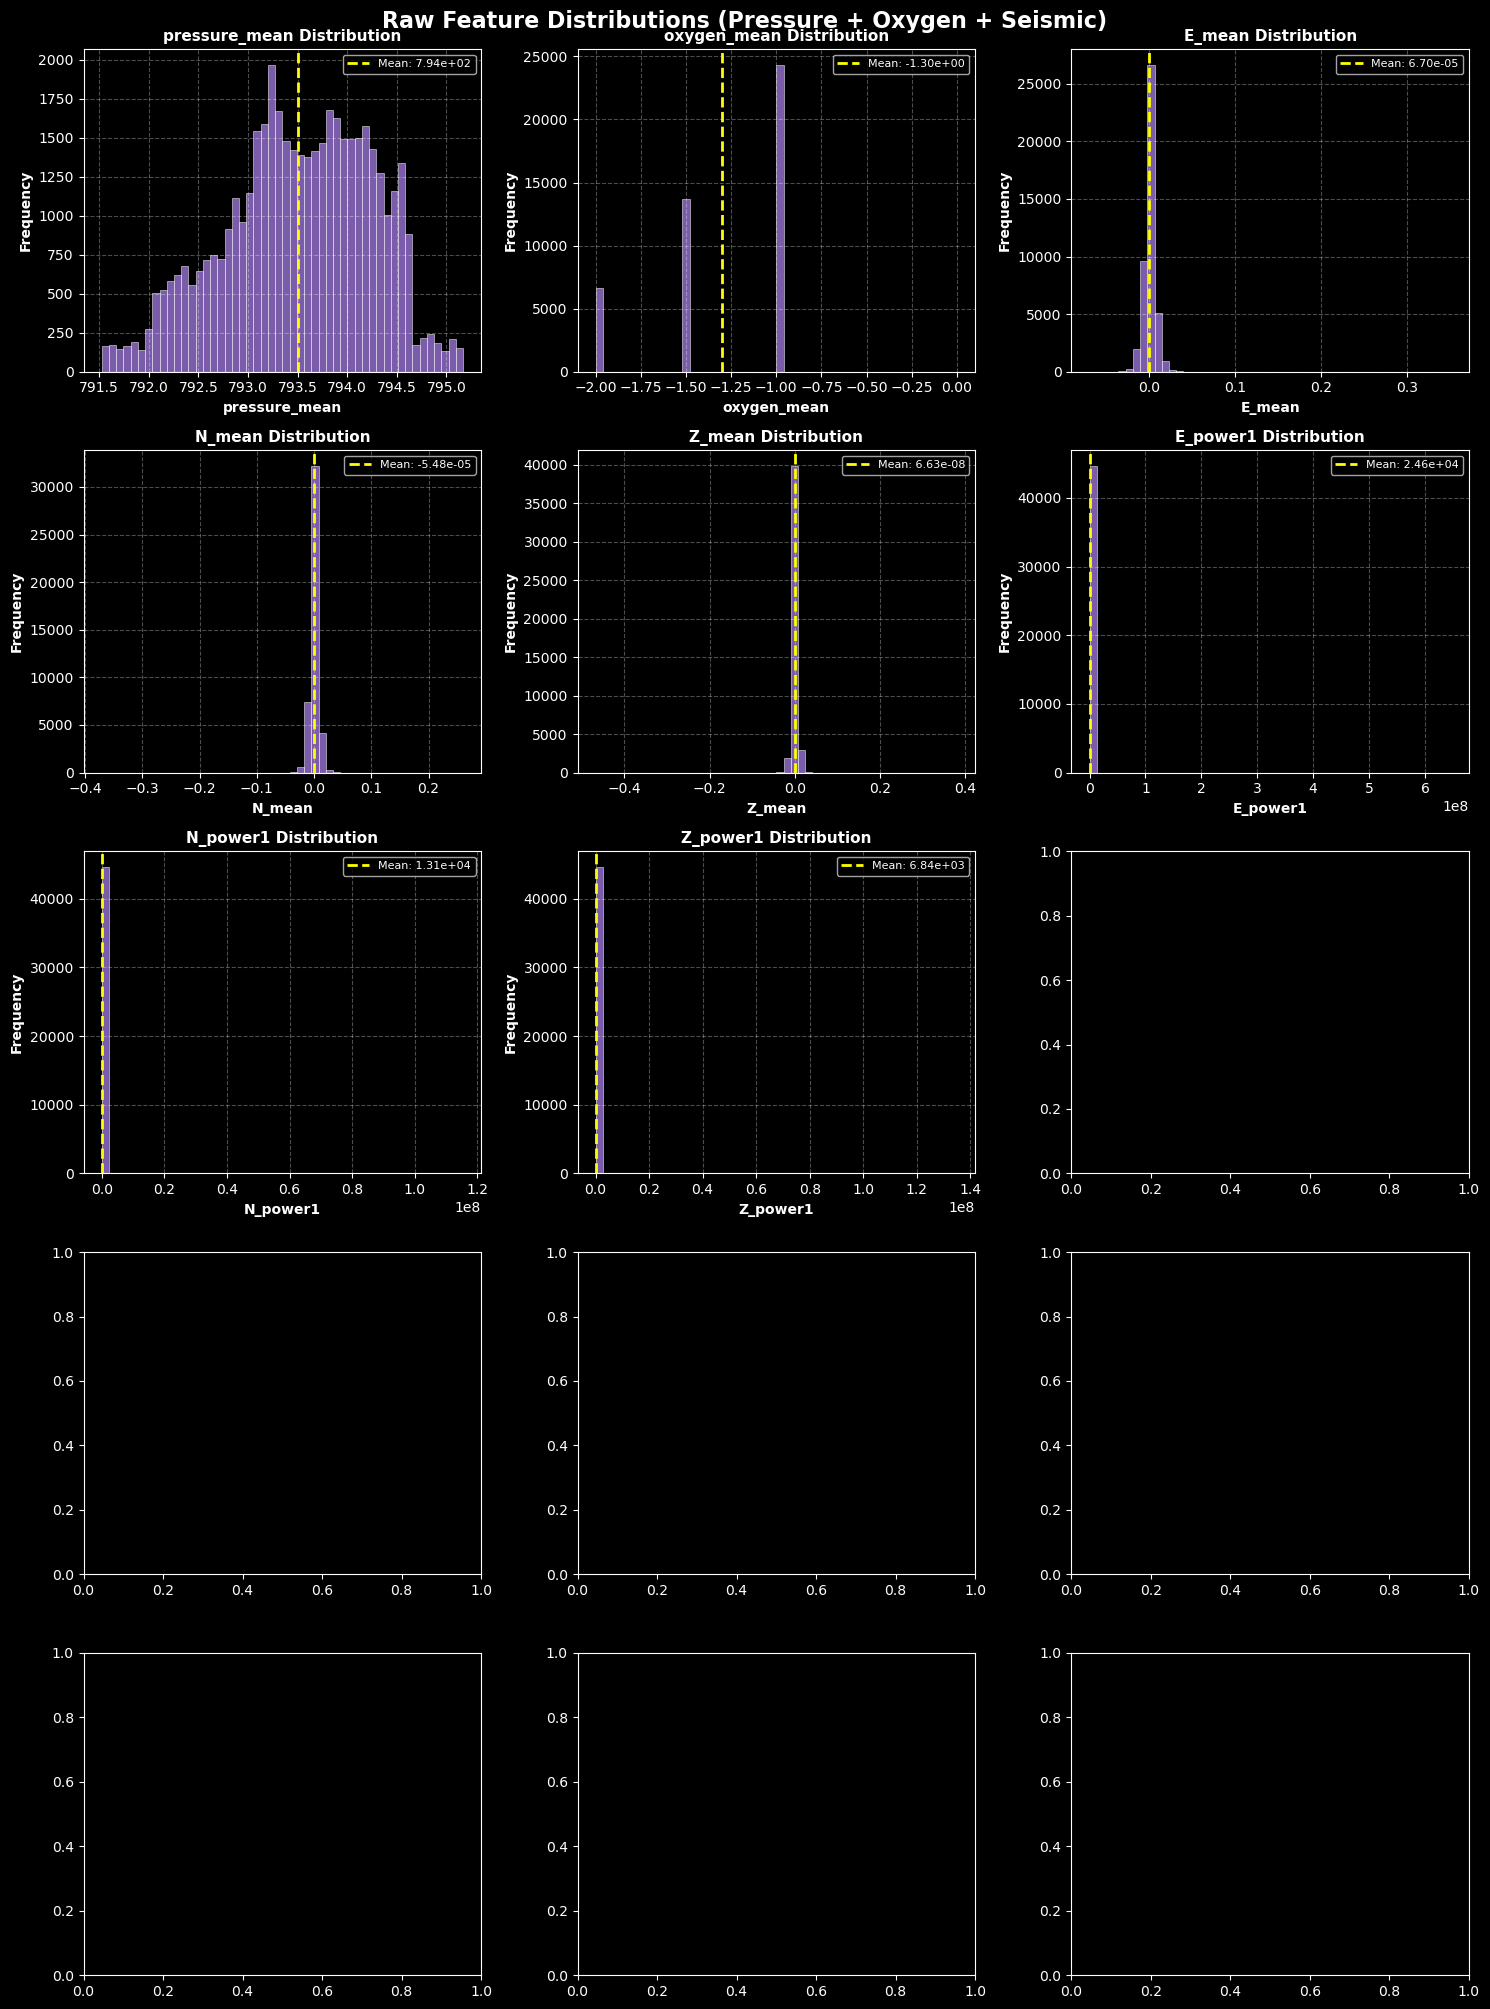

Raw feature histograms plotted


In [218]:
# Plot histograms of raw features
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for idx, feature in enumerate(all_feature_cols):
    ax = axes[idx]
    data = combined_final[feature].dropna()
    
    ax.hist(data, bins=50, color='#b084f5', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax.set_xlabel(feature, fontweight='bold', fontsize=10)
    ax.set_ylabel('Frequency', fontweight='bold', fontsize=10)
    ax.set_title(f'{feature} Distribution', fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add statistics
    mean_val = data.mean()
    std_val = data.std()
    ax.axvline(mean_val, color='yellow', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2e}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Raw Feature Distributions (Pressure + Oxygen + Seismic)', fontsize=16, fontweight='bold', y=1.002)
plt.show()

print("Raw feature histograms plotted")

## 7. Standardize Features (Demean and Scale)

In [8]:
# Extract feature matrix
X_raw = combined_final[all_feature_cols].values

# Check for NaN values
nan_counts = np.isnan(X_raw).sum(axis=0)
print("NaN counts per feature:")
for i, col in enumerate(all_feature_cols):
    if nan_counts[i] > 0:
        print(f"  {col}: {nan_counts[i]}")

# Remove any rows with NaN values
valid_rows = ~np.isnan(X_raw).any(axis=1)
X_clean = X_raw[valid_rows]
combined_analysis = combined_final[valid_rows].copy()

print(f"\nFinal dataset for analysis: {len(X_clean)} records")
print(f"Removed {len(X_raw) - len(X_clean)} records with NaN values")

NameError: name 'combined_final' is not defined

In [220]:
# Save combined_final as a csv file
combined_analysis.to_csv('pressure-seismic-oxygen-data-6-months.csv')

In [4]:
#########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Load the combined dataset for analysis
combined_analysis = pd.read_csv('pressure-seismic-oxygen-data-6-months.csv')
combined_analysis['date'] = pd.to_datetime(combined_analysis['date'])
print(f"Loaded combined dataset with {len(combined_analysis)} records")
print(f"Date range: {combined_analysis['date'].min()} to {combined_analysis['date'].max()}")

Loaded combined dataset with 44698 records
Date range: 2018-06-30 00:00:00 to 2018-07-31 00:00:00


In [6]:
# Apply StandardScaler (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("Features standardized using StandardScaler")
print(f"\nScaled data shape: {X_scaled.shape}")
print(f"\nMean of scaled features (should be ~0):")
print(np.mean(X_scaled, axis=0))
print(f"\nStd of scaled features (should be ~1):")
print(np.std(X_scaled, axis=0))

NameError: name 'X_clean' is not defined

In [222]:
# Create DataFrame with scaled features for easier plotting
scaled_feature_names = [f'{col}_scaled' for col in all_feature_cols]
scaled_df = pd.DataFrame(X_scaled, columns=scaled_feature_names, index=combined_analysis.index)

print("Created DataFrame with scaled features")
scaled_df.head()

Created DataFrame with scaled features


,pressure_mean_scaled,oxygen_mean_scaled,E_mean_scaled,N_mean_scaled,Z_mean_scaled,E_power1_scaled,N_power1_scaled,Z_power1_scaled
2779,0.599560,0.822921,-0.701865,-0.285271,0.834319,-0.007548,-0.018526,-0.007890
2780,0.594877,0.822921,1.409581,-0.829111,-0.421750,-0.007527,-0.019456,-0.006061
2781,0.586637,0.822921,0.780456,-1.409632,-0.337667,-0.007412,-0.020491,-0.008285
2782,0.579743,-0.542950,0.145211,-0.863065,-0.450619,-0.007466,-0.020687,-0.008771
2783,0.574290,0.822921,-0.544872,0.355329,-0.970413,-0.007284,-0.019457,-0.007509


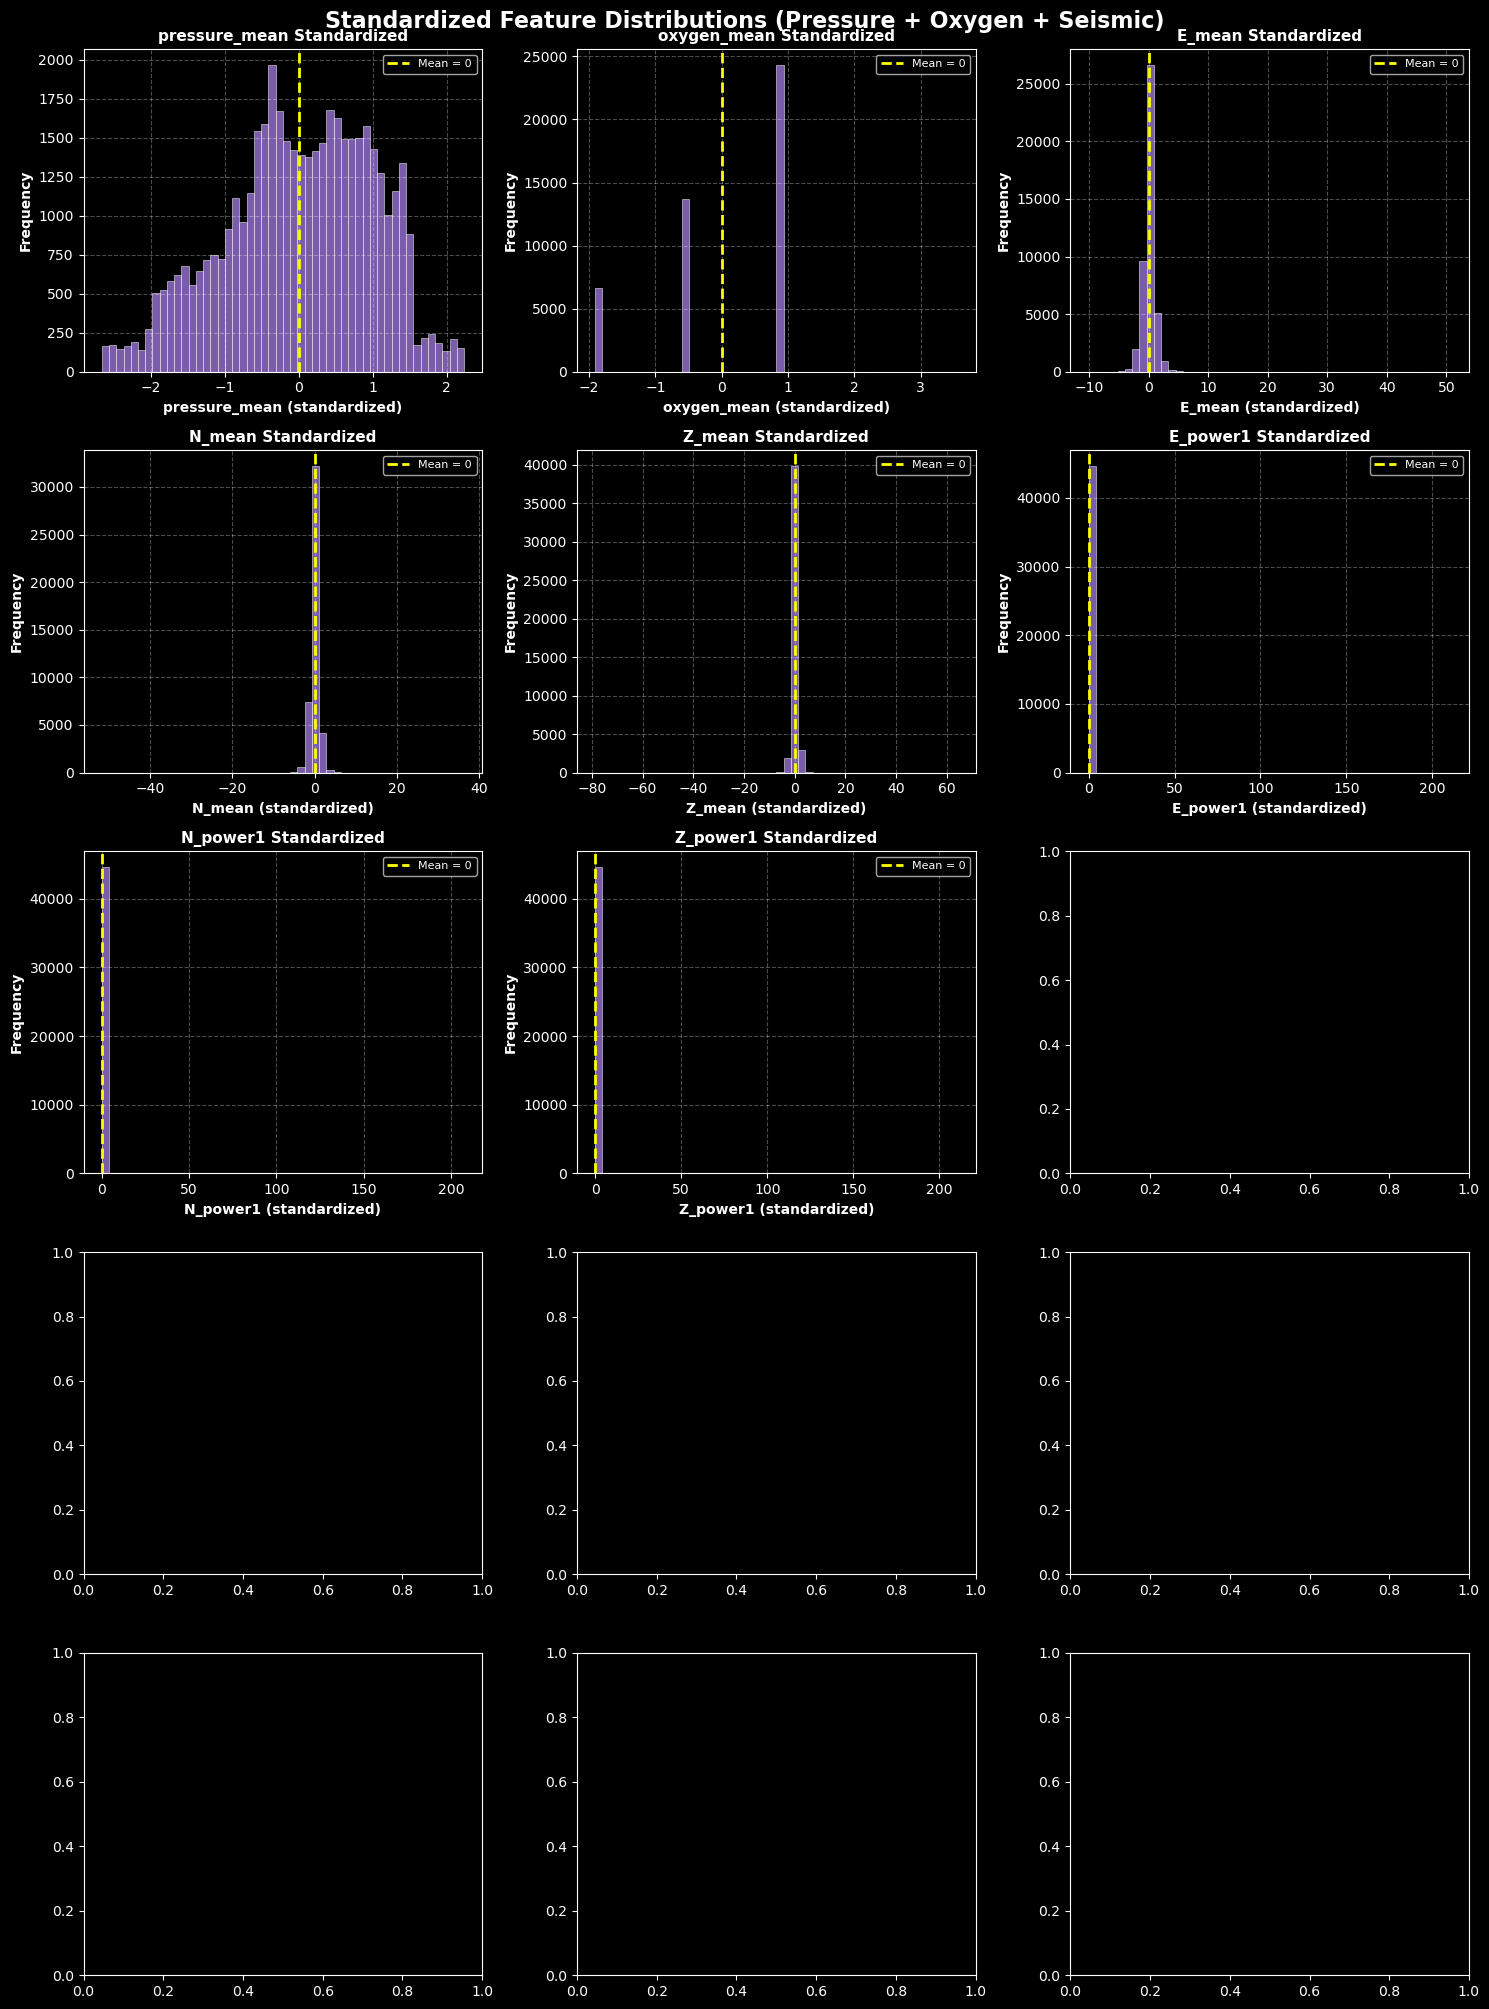

Standardized feature histograms plotted


In [223]:
# Plot histograms of standardized features
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for idx, (feature, scaled_col) in enumerate(zip(all_feature_cols, scaled_feature_names)):
    ax = axes[idx]
    data = scaled_df[scaled_col]
    
    ax.hist(data, bins=50, color='#b084f5', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax.set_xlabel(f'{feature} (standardized)', fontweight='bold', fontsize=10)
    ax.set_ylabel('Frequency', fontweight='bold', fontsize=10)
    ax.set_title(f'{feature} Standardized', fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add zero line
    ax.axvline(0, color='yellow', linestyle='--', linewidth=2, label='Mean = 0')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Standardized Feature Distributions (Pressure + Oxygen + Seismic)', fontsize=16, fontweight='bold', y=1.002)
plt.show()

print("Standardized feature histograms plotted")

## 8. Feature Cross-Correlations

In [224]:
# Compute correlation matrix
corr_matrix = np.corrcoef(X_scaled.T)

print(f"Correlation matrix shape: {corr_matrix.shape}")
print(f"\nCorrelation matrix computed for {len(all_feature_cols)} features")

Correlation matrix shape: (8, 8)

Correlation matrix computed for 8 features


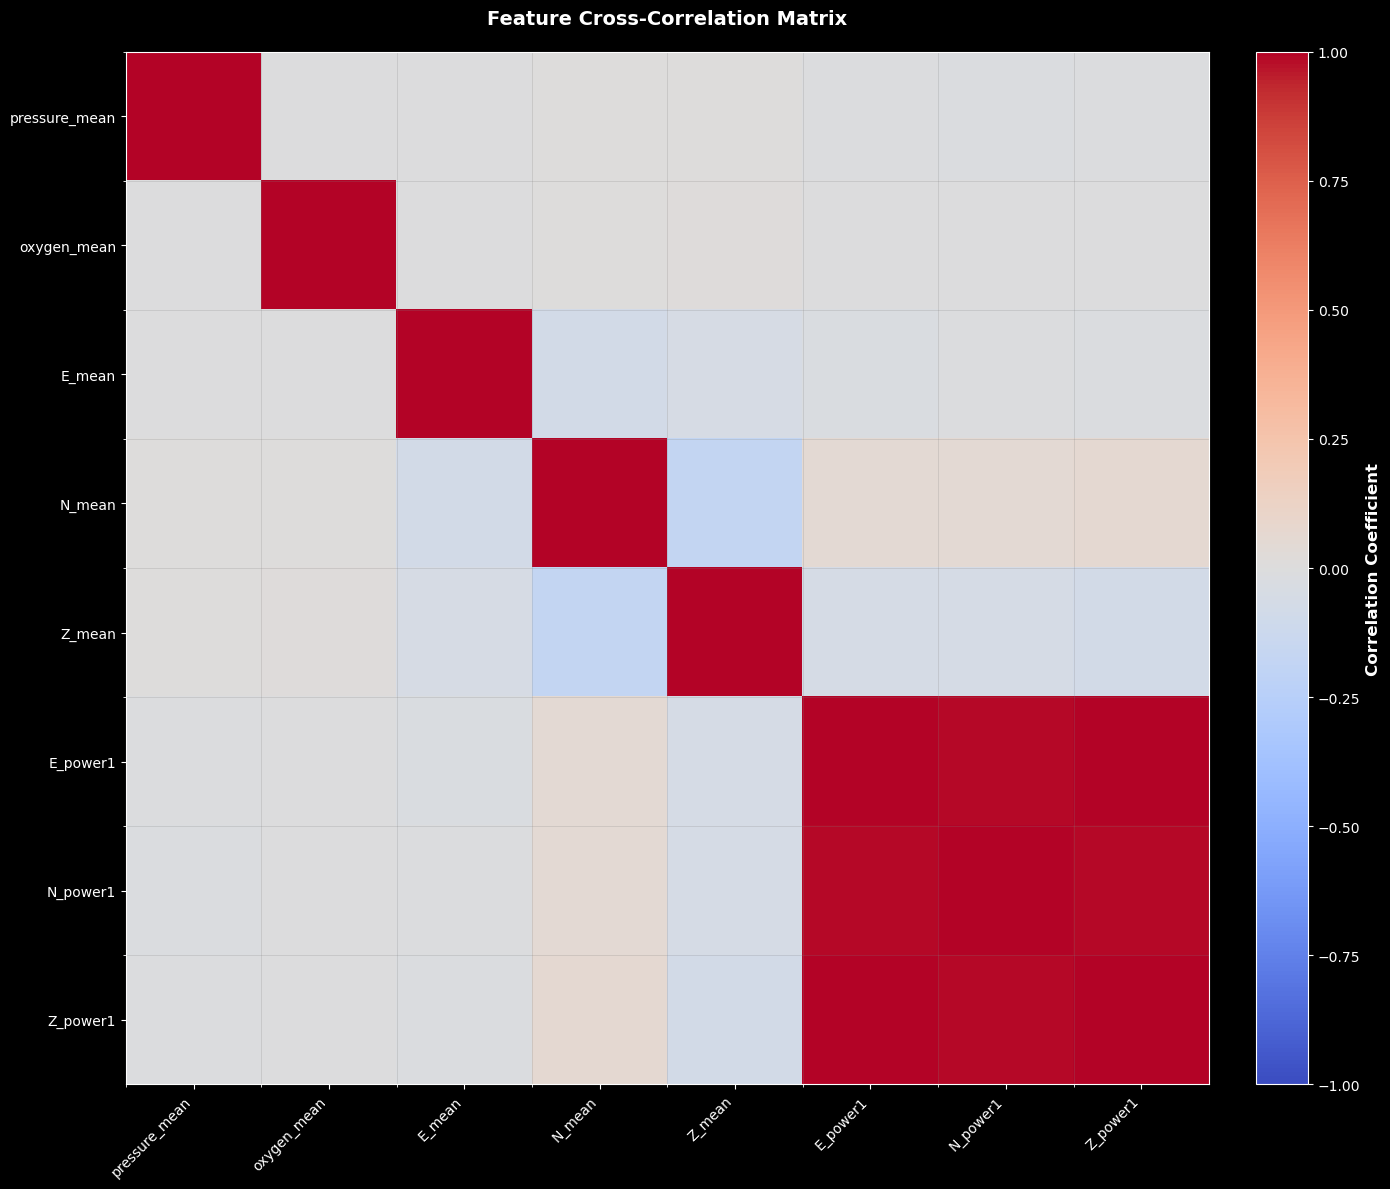

Correlation heatmap plotted


In [225]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(all_feature_cols)))
ax.set_yticks(np.arange(len(all_feature_cols)))
ax.set_xticklabels(all_feature_cols, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(all_feature_cols, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontweight='bold', fontsize=12)

# Add title
ax.set_title('Feature Cross-Correlation Matrix', fontweight='bold', fontsize=14, pad=20)

# Add gridlines
ax.set_xticks(np.arange(len(all_feature_cols)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(all_feature_cols)) - 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("Correlation heatmap plotted")

In [226]:
X_scaled

array([[ 0.59956033,  0.8229206 , -0.70186514, ..., -0.00754773,
        -0.01852561, -0.00788956],
       [ 0.5948772 ,  0.8229206 ,  1.40958123, ..., -0.00752707,
        -0.01945588, -0.00606082],
       [ 0.58663736,  0.8229206 ,  0.78045602, ..., -0.00741179,
        -0.02049109, -0.00828532],
       ...,
       [ 0.85900656,  0.8229206 , -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529],
       [ 0.85334792,  0.8229206 , -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529],
       [ 0.84839308, -0.54295036, -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529]], shape=(44698, 8))

In [227]:
# Identify strongest correlations between pressure/oxygen and seismic features
print("Strongest correlations between environmental (pressure/oxygen) and seismic features:\n")

env_feature_cols = pressure_feature_cols + oxygen_feature_cols

for env_idx, env_feature in enumerate(env_feature_cols):
    print(f"\n{env_feature}:")
    correlations = []
    
    for s_idx, s_feature in enumerate(seismic_feature_cols):
        corr_val = corr_matrix[env_idx, len(env_feature_cols) + s_idx]
        correlations.append((s_feature, corr_val))
    
    # Sort by absolute correlation value
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Display top 3
    for s_feature, corr_val in correlations[:3]:
        print(f"  {s_feature}: {corr_val:+.3f}")

Strongest correlations between environmental (pressure/oxygen) and seismic features:


pressure_mean:
  N_power1: -0.019
  E_power1: -0.011
  Z_power1: -0.011

oxygen_mean:
  Z_mean: +0.009
  N_power1: -0.004
  Z_power1: -0.003


In [228]:
X_scaled

array([[ 0.59956033,  0.8229206 , -0.70186514, ..., -0.00754773,
        -0.01852561, -0.00788956],
       [ 0.5948772 ,  0.8229206 ,  1.40958123, ..., -0.00752707,
        -0.01945588, -0.00606082],
       [ 0.58663736,  0.8229206 ,  0.78045602, ..., -0.00741179,
        -0.02049109, -0.00828532],
       ...,
       [ 0.85900656,  0.8229206 , -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529],
       [ 0.85334792,  0.8229206 , -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529],
       [ 0.84839308, -0.54295036, -0.00967519, ..., -0.00801892,
        -0.02356247, -0.01066529]], shape=(44698, 8))

## 9. PCA Analysis for Variance Explanation

In [229]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"PCA applied to {X_scaled[1]} features")
print(f"Number of principal components: {pca.n_components_}")
print(f"\nExplained variance ratio for first 5 components:")
for i in range(min(5, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")

PCA applied to [ 0.5948772   0.8229206   1.40958123 -0.82911101 -0.42174991 -0.00752707
 -0.01945588 -0.00606082] features
Number of principal components: 8

Explained variance ratio for first 5 components:
  PC1: 0.3746 (37.46%)
  PC2: 0.1455 (14.55%)
  PC3: 0.1292 (12.92%)
  PC4: 0.1256 (12.56%)
  PC5: 0.1242 (12.42%)


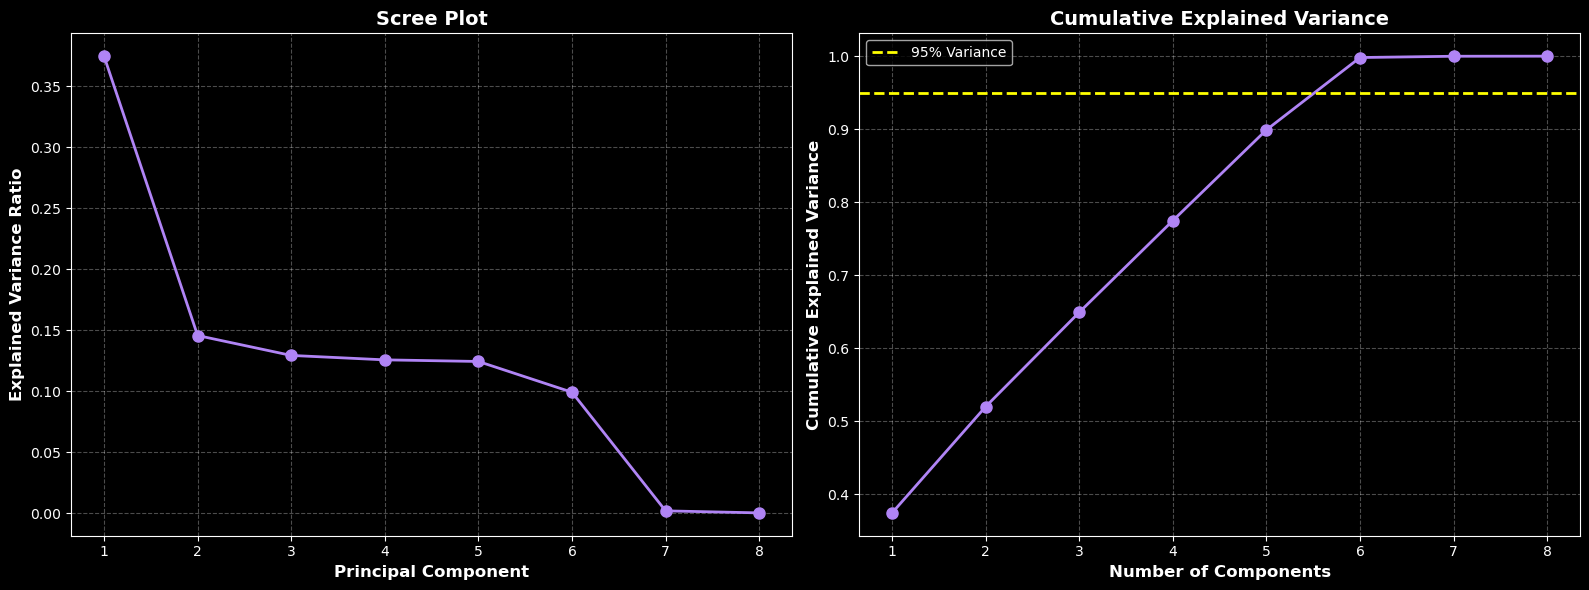


Number of components explaining 95% variance: 6
Cumulative variance with 6 components: 0.9981


In [230]:
# Plot scree plot and cumulative variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 
         'o-', color='#b084f5', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component', fontweight='bold', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontweight='bold', fontsize=12)
ax1.set_title('Scree Plot', fontweight='bold', fontsize=14)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xticks(range(1, len(pca.explained_variance_ratio_) + 1))

# Cumulative variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, len(cumulative_variance) + 1), 
         cumulative_variance, 
         'o-', color='#b084f5', linewidth=2, markersize=8)
ax2.axhline(y=0.95, color='yellow', linestyle='--', linewidth=2, label='95% Variance')
ax2.set_xlabel('Number of Components', fontweight='bold', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontweight='bold', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(fontsize=10)
ax2.set_xticks(range(1, len(cumulative_variance) + 1))

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components_95}")
print(f"Cumulative variance with {n_components_95} components: {cumulative_variance[n_components_95-1]:.4f}")

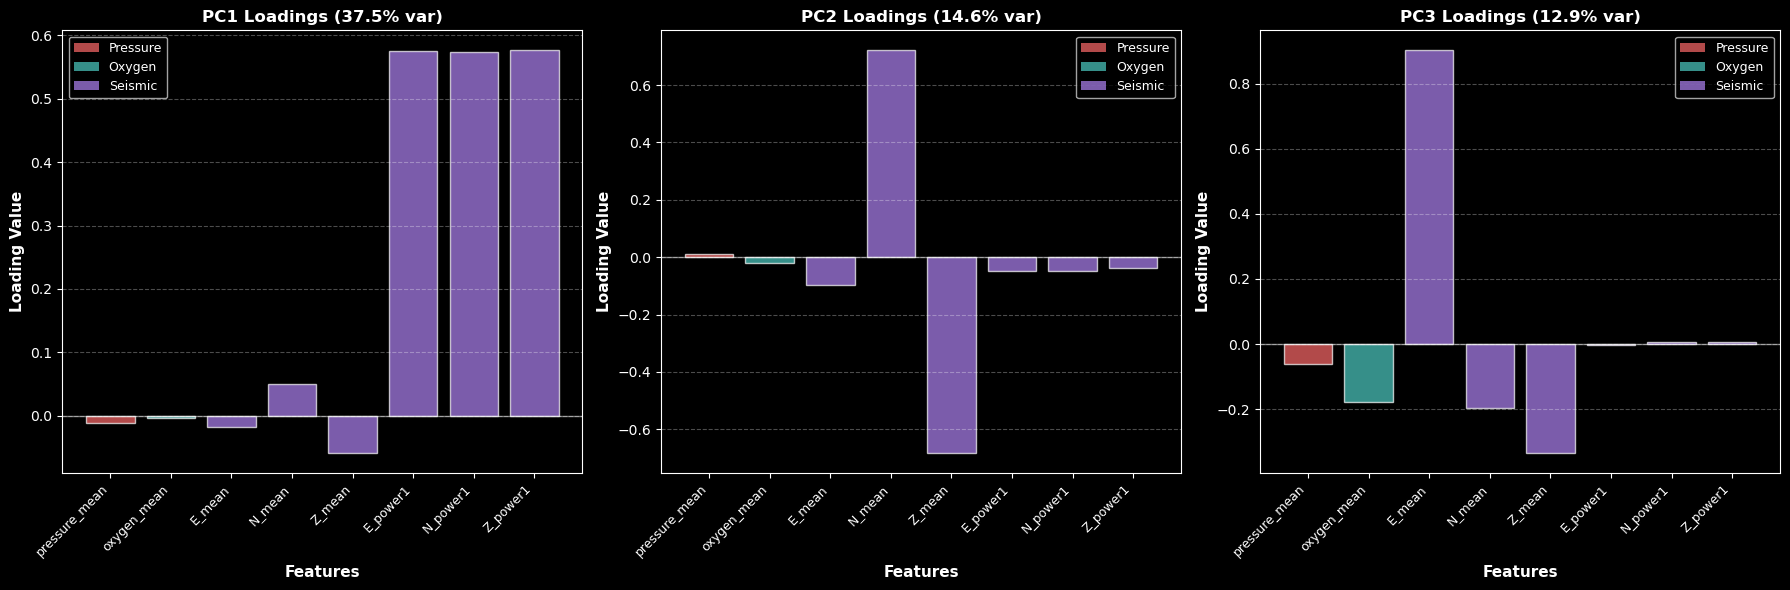


PCA loadings plotted for top components


In [231]:
# Analyze loadings for top principal components
n_top_components = min(3, pca.n_components_)

fig, axes = plt.subplots(1, n_top_components, figsize=(18, 6))
if n_top_components == 1:
    axes = [axes]

for i in range(n_top_components):
    ax = axes[i]
    loadings = pca.components_[i]
    
    # Create bar plot with different colors for pressure, oxygen, and seismic
    colors = []
    for j in range(len(all_feature_cols)):
        if j < len(pressure_feature_cols):
            colors.append('#ff6b6b')  # Red for pressure
        elif j < len(pressure_feature_cols) + len(oxygen_feature_cols):
            colors.append('#4ecdc4')  # Cyan for oxygen
        else:
            colors.append('#b084f5')  # Purple for seismic
    
    bars = ax.bar(range(len(all_feature_cols)), loadings, color=colors, alpha=0.7, edgecolor='white')
    ax.set_xlabel('Features', fontweight='bold', fontsize=11)
    ax.set_ylabel('Loading Value', fontweight='bold', fontsize=11)
    ax.set_title(f'PC{i+1} Loadings ({pca.explained_variance_ratio_[i]*100:.1f}% var)', 
                 fontweight='bold', fontsize=12)
    ax.set_xticks(range(len(all_feature_cols)))
    ax.set_xticklabels(all_feature_cols, rotation=45, ha='right', fontsize=9)
    ax.grid(alpha=0.3, linestyle='--', axis='y')
    ax.axhline(y=0, color='white', linestyle='-', linewidth=1, alpha=0.5)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#ff6b6b', alpha=0.7, label='Pressure'),
                       Patch(facecolor='#4ecdc4', alpha=0.7, label='Oxygen'),
                       Patch(facecolor='#b084f5', alpha=0.7, label='Seismic')]
    ax.legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
plt.show()

print("\nPCA loadings plotted for top components")

In [232]:
# Display top contributing features for each principal component
print("Top 5 contributing features for each principal component:\n")

for i in range(n_top_components):
    print(f"\nPC{i+1} (explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance):")
    
    loadings = pca.components_[i]
    feature_importance = [(all_feature_cols[j], abs(loadings[j]), loadings[j]) 
                          for j in range(len(all_feature_cols))]
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    for feature, abs_load, load in feature_importance[:5]:
        print(f"  {feature}: {load:+.3f}")

Top 5 contributing features for each principal component:


PC1 (explains 37.46% of variance):
  Z_power1: +0.576
  E_power1: +0.576
  N_power1: +0.574
  Z_mean: -0.058
  N_mean: +0.050

PC2 (explains 14.55% of variance):
  N_mean: +0.720
  Z_mean: -0.682
  E_mean: -0.098
  N_power1: -0.049
  E_power1: -0.048

PC3 (explains 12.92% of variance):
  E_mean: +0.902
  Z_mean: -0.334
  N_mean: -0.196
  oxygen_mean: -0.180
  pressure_mean: -0.061


NameError: name 'X_pca' is not defined

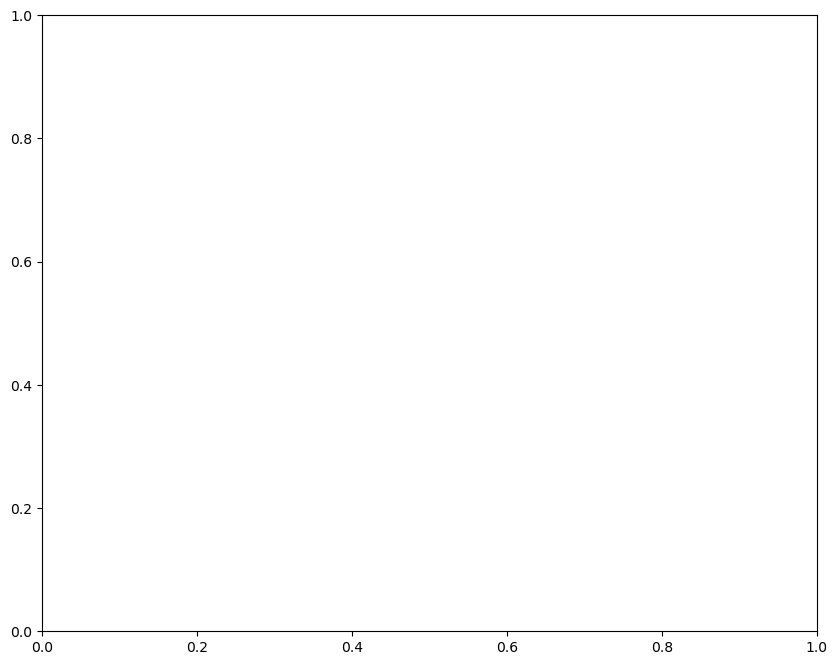

In [7]:
# Project data onto first two principal components for visualization
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=combined_analysis['date'].values.astype('int64') // 10**9,
                     cmap='viridis', alpha=0.6, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_title('Data Projected onto First Two Principal Components', 
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, linestyle='--')

ax.set_xlim(-5, 5)
ax.set_ylim(-10,10)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time (Unix timestamp)', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("PCA projection plotted")

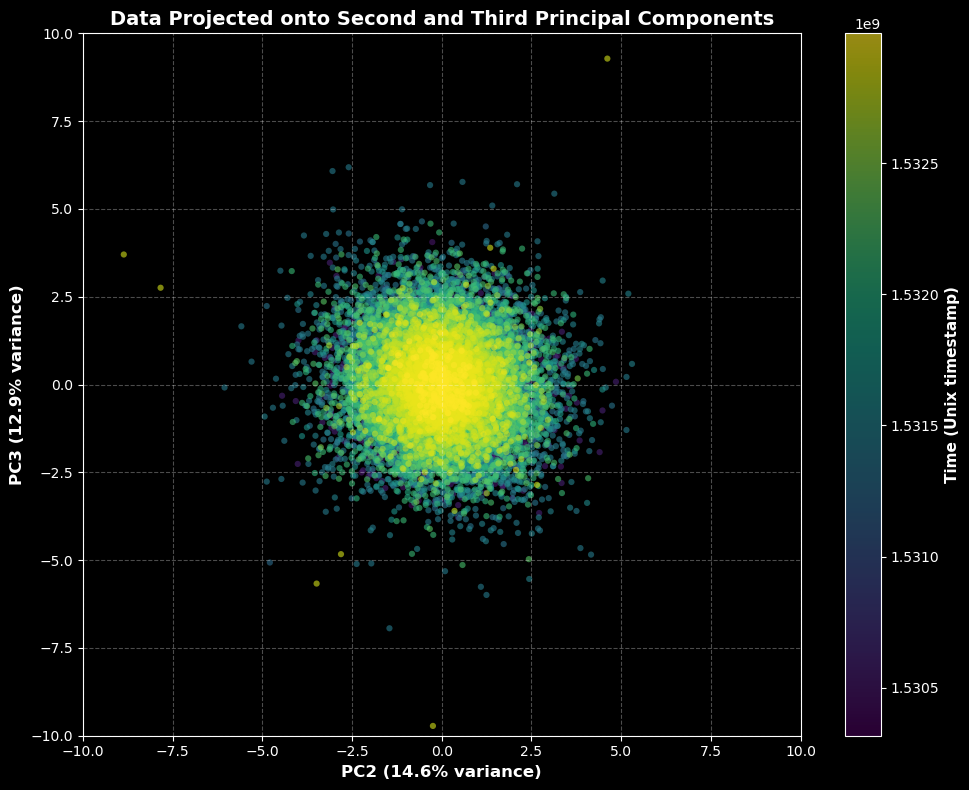

PCA projection plotted


In [245]:
# Project data onto PC2 vs. PC3 for visualization
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_pca[:, 1], X_pca[:, 2], 
                     c=combined_analysis['date'].values.astype('int64') // 10**9,
                     cmap='viridis', alpha=0.6, s=20, edgecolors='none')

ax.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_title('Data Projected onto Second and Third Principal Components', 
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, linestyle='--')

ax.set_xlim(-10, 10)
ax.set_ylim(-10,10)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time (Unix timestamp)', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("PCA projection plotted")

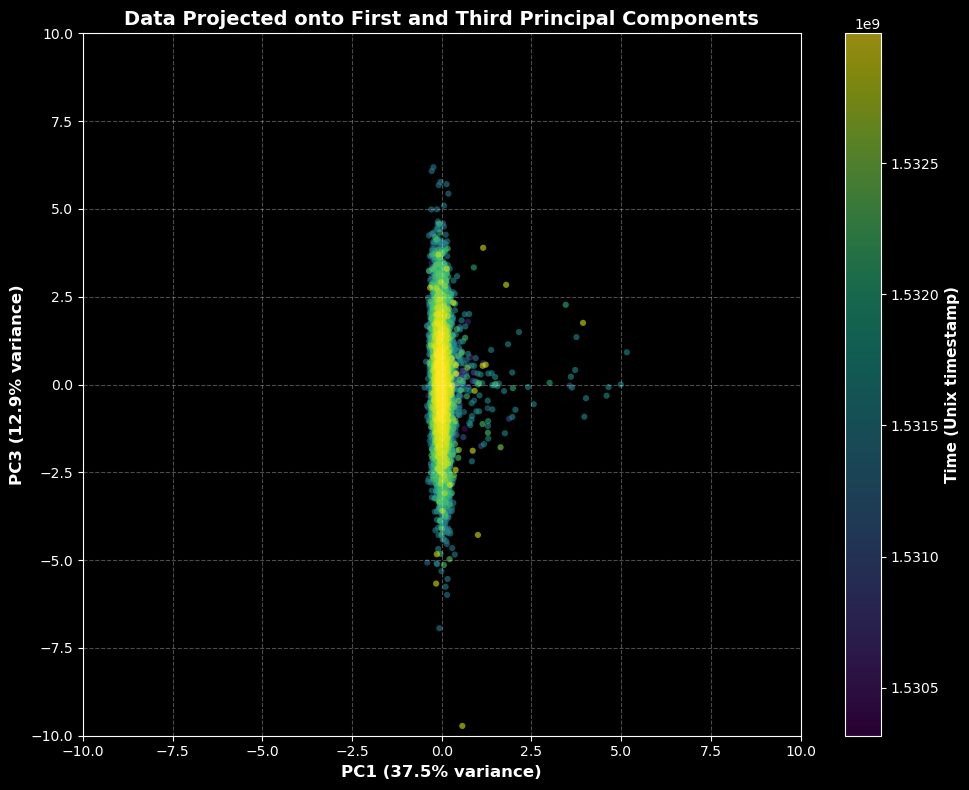

PCA projection plotted


In [247]:
# Project data onto PC1 vs. PC3 for visualization
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 2], 
                     c=combined_analysis['date'].values.astype('int64') // 10**9,
                     cmap='viridis', alpha=0.6, s=20, edgecolors='none')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_title('Data Projected onto First and Third Principal Components', 
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, linestyle='--')

ax.set_xlim(-10, 10)
ax.set_ylim(-10,10)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time (Unix timestamp)', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("PCA projection plotted")

## Summary

This notebook has:
1. ✓ Parsed MASSPA dissolved oxygen data files and saved to CSV
2. ✓ Loaded seismic features and extracted temporal structure
3. ✓ Aligned pressure data to seismic 2-hour time bins
4. ✓ Aligned dissolved oxygen data to seismic 2-hour time bins
5. ✓ Extracted features from all three data types (min, max, mean)
6. ✓ Visualized raw feature distributions
7. ✓ Standardized all features (zero mean, unit variance)
8. ✓ Visualized standardized feature distributions
9. ✓ Computed and plotted feature cross-correlations
10. ✓ Applied PCA to identify variance-explaining features

Key findings can be extracted from:
- Correlation matrix showing pressure/oxygen/seismic relationships
- PCA loadings indicating which features drive most variance
- Number of components needed to explain 95% of variance
- Relative contributions of pressure, oxygen, and seismic features to principal components

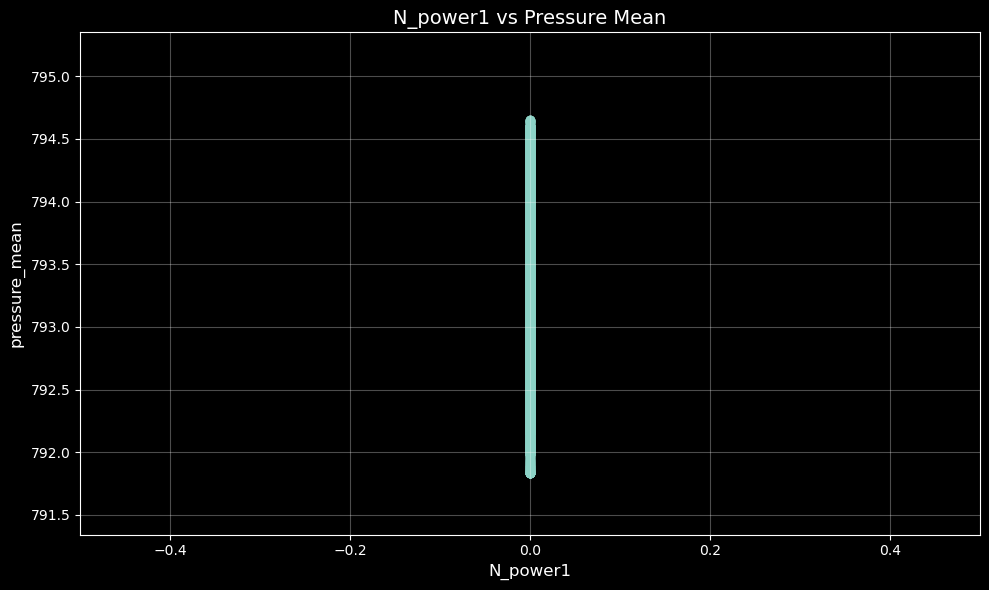

In [248]:
# Make a scatter plot of N_power1 (x-axis) vs pressure_mean
plt.figure(figsize=(10, 6))
plt.scatter(combined_final['N_power1'], combined_final['pressure_mean'], alpha=0.5)
plt.xlabel('N_power1', fontsize=12)
plt.ylabel('pressure_mean', fontsize=12)
plt.title('N_power1 vs Pressure Mean', fontsize=14)
plt.xlim(-0.5, 0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

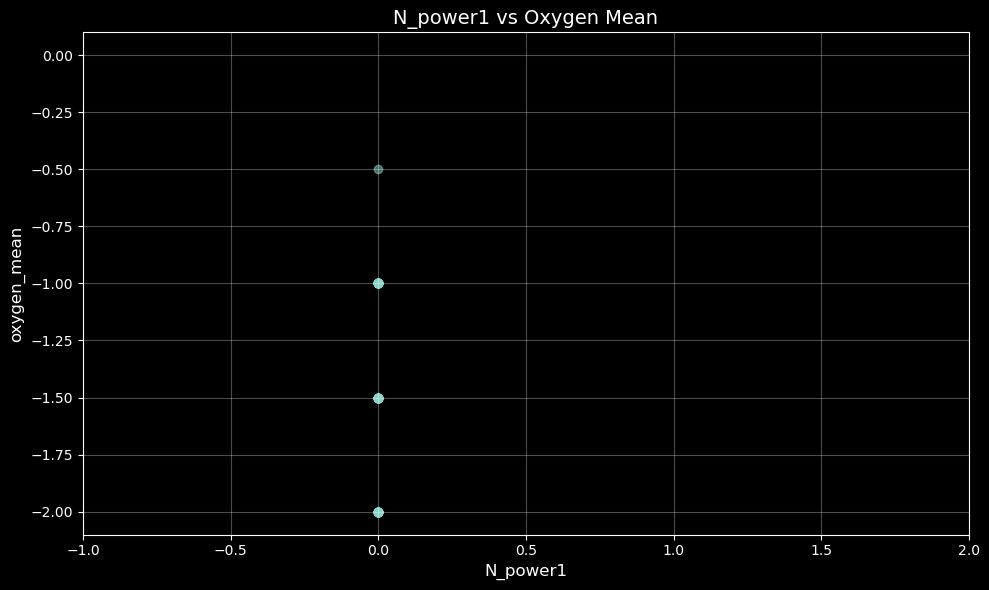

In [237]:
# Make a scatter plot of N_power1 vs. oxygen_mean
plt.figure(figsize=(10, 6))
plt.scatter(combined_final['N_power1'], combined_final['oxygen_mean'], alpha=0.5)
plt.xlabel('N_power1', fontsize=12)
plt.ylabel('oxygen_mean', fontsize=12)
plt.title('N_power1 vs Oxygen Mean', fontsize=14)
plt.xlim(-1, 2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

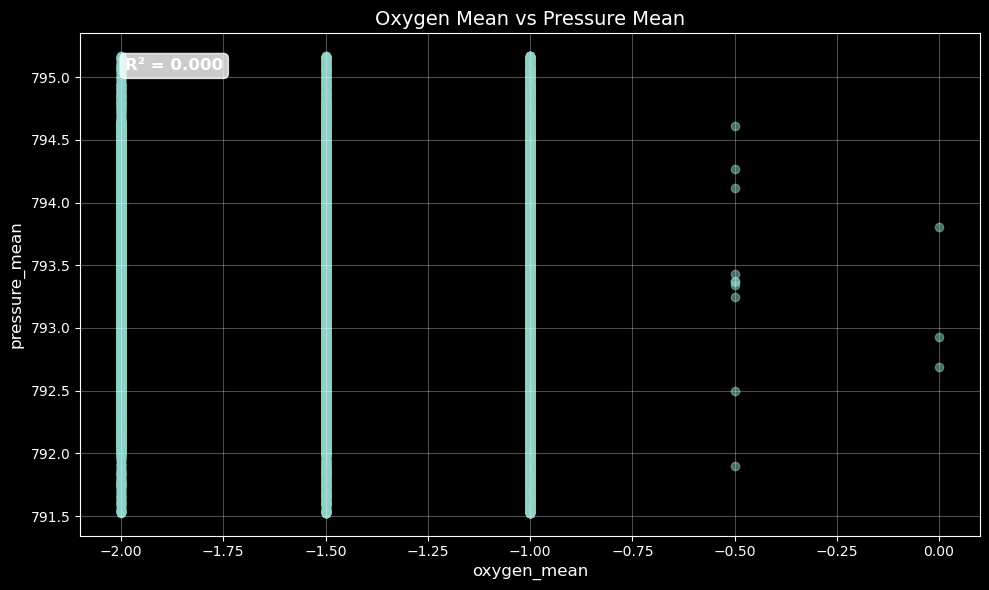

In [238]:
# Make a scatter plot of oxygen_mean vs. pressure_mean
# Add r-squared value to the plot
from sklearn.linear_model import LinearRegression
# Prepare data
X = combined_final['oxygen_mean'].values.reshape(-1, 1)
y = combined_final['pressure_mean'].values.reshape(-1,1)
# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(combined_final['oxygen_mean'], combined_final['pressure_mean'], alpha=0.5)
plt.xlabel('oxygen_mean', fontsize=12)
plt.ylabel('pressure_mean', fontsize=12)
plt.title('Oxygen Mean vs Pressure Mean', fontsize=14)
plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, fontweight='bold', verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

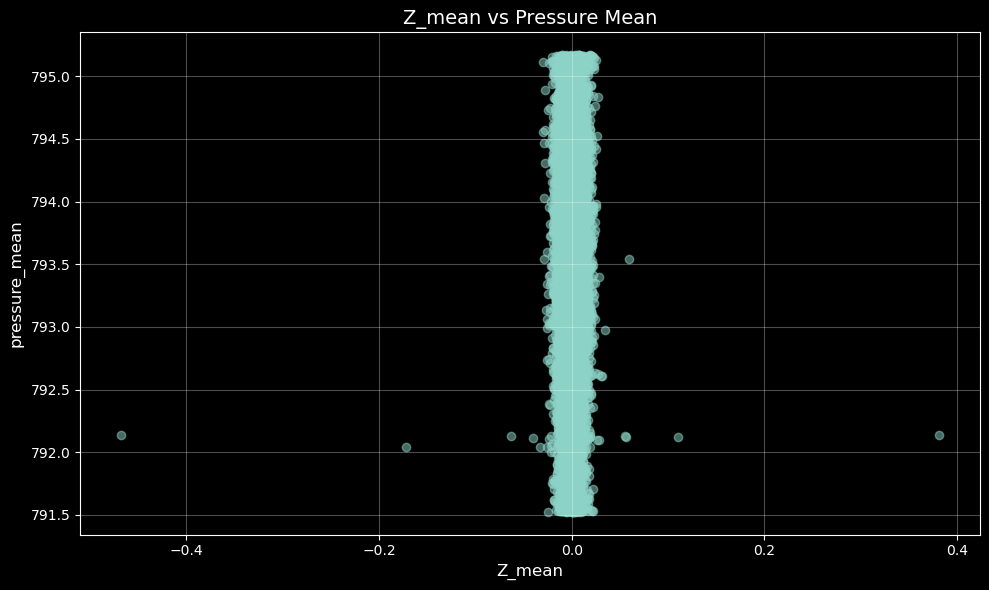

In [239]:
# Plot Z_mean vs. pressure_mean
plt.figure(figsize=(10, 6))
plt.scatter(combined_final['Z_mean'], combined_final['pressure_mean'], alpha=0.5)
plt.xlabel('Z_mean', fontsize=12)
plt.ylabel('pressure_mean', fontsize=12)
plt.title('Z_mean vs Pressure Mean', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

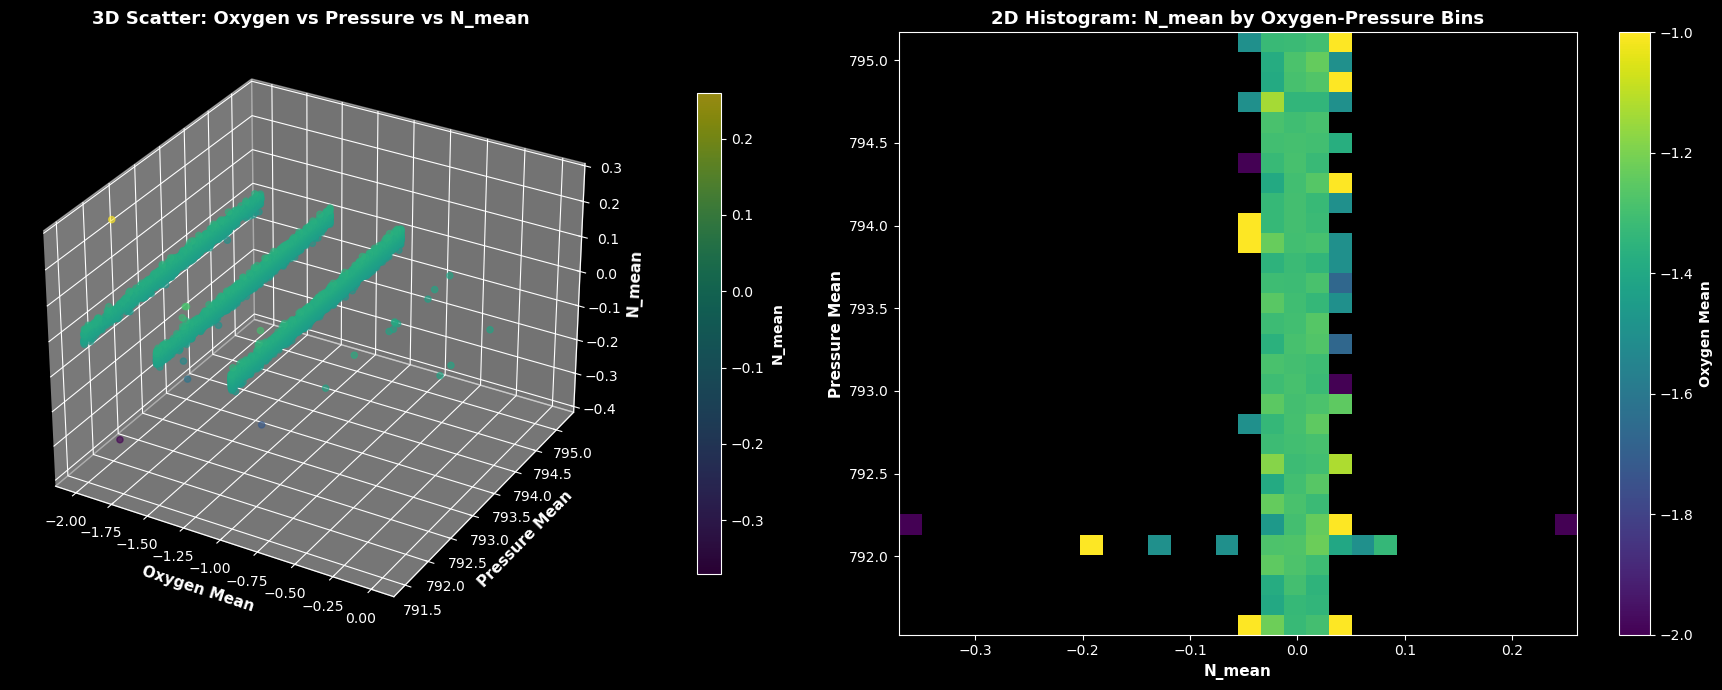

In [249]:
# Make a 3D scatter plot and 2D histogram of oxygen_mean vs. pressure_mean vs. N_mean
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_2d

fig = plt.figure(figsize=(18, 7))

# 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(combined_final['oxygen_mean'], 
                      combined_final['pressure_mean'], 
                      combined_final['N_mean'],
                      c=combined_final['N_mean'], 
                      cmap='viridis', 
                      alpha=0.6, 
                      s=20)
ax1.set_xlabel('Oxygen Mean', fontsize=11, fontweight='bold')
ax1.set_ylabel('Pressure Mean', fontsize=11, fontweight='bold')
ax1.set_zlabel('N_mean', fontsize=11, fontweight='bold')
ax1.set_title('3D Scatter: Oxygen vs Pressure vs N_mean', fontsize=13, fontweight='bold')
cbar1 = plt.colorbar(scatter, ax=ax1, pad=0.1, shrink=0.8)
cbar1.set_label('N_mean', fontsize=10, fontweight='bold')

# 2D histogram with N_mean as color
ax2 = fig.add_subplot(122)
# Calculate binned statistics - mean of N_mean in each bin
z = combined_final['oxygen_mean'].values
y = combined_final['pressure_mean'].values
x = combined_final['N_mean'].values

# Remove NaN values
mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
x, y, z = x[mask], y[mask], z[mask]

# Create 2D histogram with N_mean as the statistic
statistic, x_edges, y_edges, _ = binned_statistic_2d(
    x, y, z, statistic='mean', bins=30
)

# Plot
im = ax2.imshow(statistic.T, origin='lower', 
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                aspect='auto', cmap='viridis', interpolation='nearest')
ax2.set_xlabel('N_mean', fontsize=11, fontweight='bold')
ax2.set_ylabel('Pressure Mean', fontsize=11, fontweight='bold')
ax2.set_title('2D Histogram: N_mean by Oxygen-Pressure Bins', fontsize=13, fontweight='bold')
cbar2 = plt.colorbar(im, ax=ax2)
cbar2.set_label('Oxygen Mean', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()